(3, 1833)
(181, 1833)
(2, 1833)


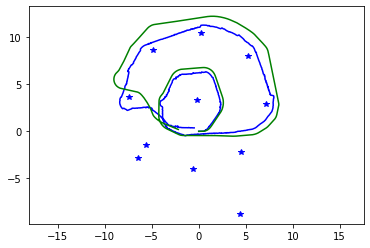

iteración ICM :  1


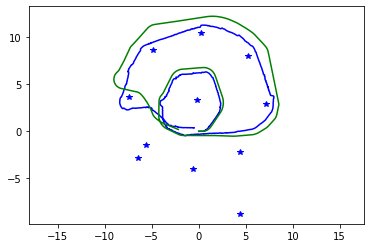

iteración ICM :  2


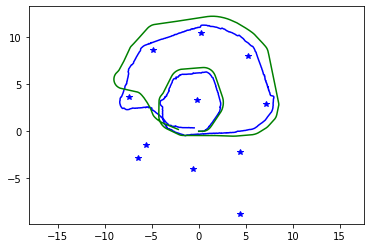

iteración ICM :  3


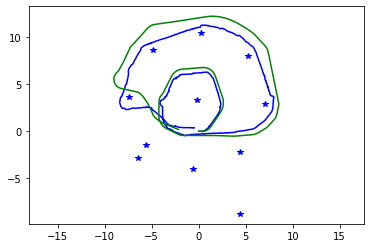

iteración ICM :  4


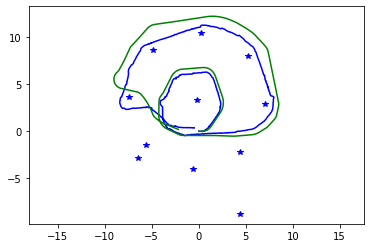

iteración ICM :  5


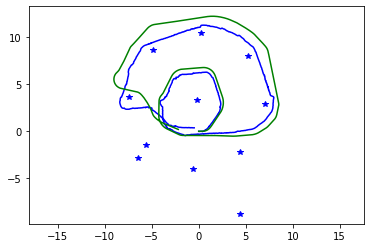

iteración ICM :  6


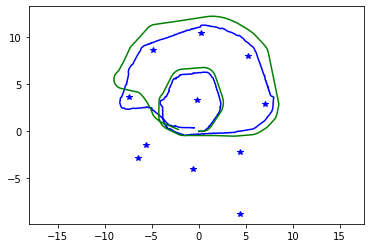

iteración ICM :  7


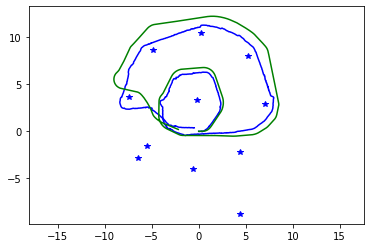

iteración ICM :  8


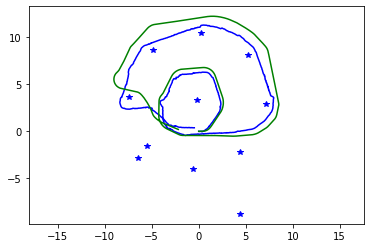

iteración ICM :  9


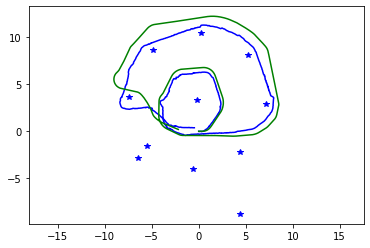

iteración ICM :  10


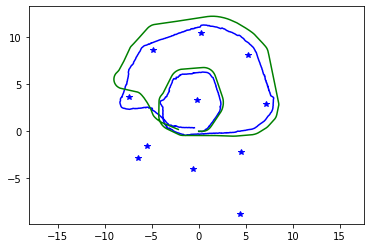

iteración ICM :  11


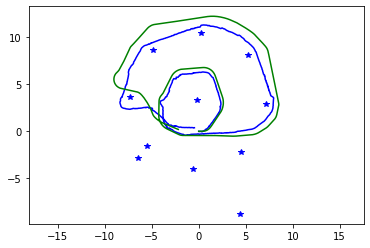

iteración ICM :  12


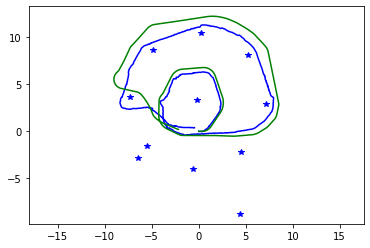

iteración ICM :  13


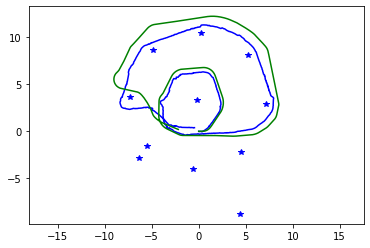

iteración ICM :  14


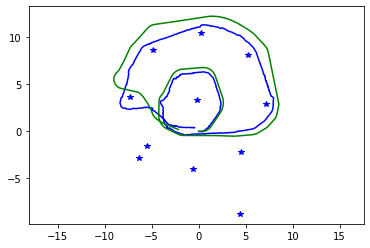

iteración ICM :  15


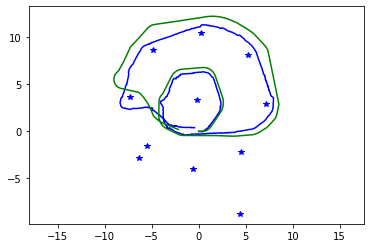

iteración ICM :  16


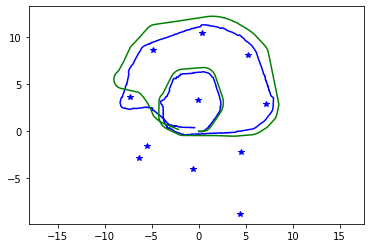

iteración ICM :  17


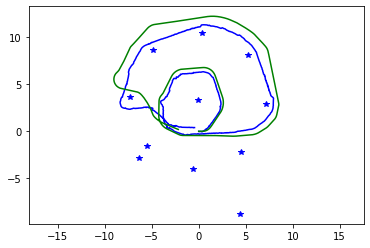

iteración ICM :  18


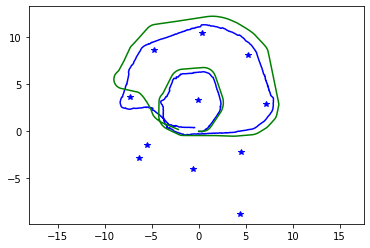

iteración ICM :  19


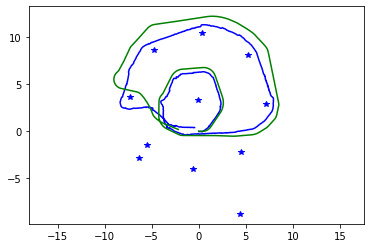

iteración ICM :  20


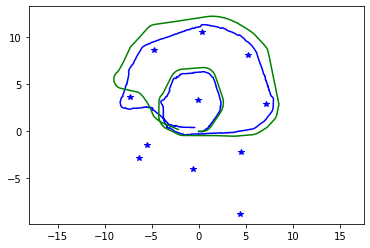

iteración ICM :  21


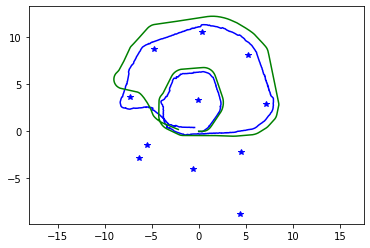

iteración ICM :  22


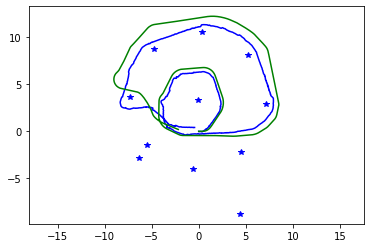

iteración ICM :  23


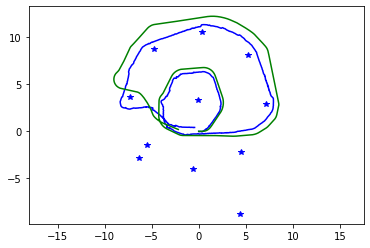

iteración ICM :  24


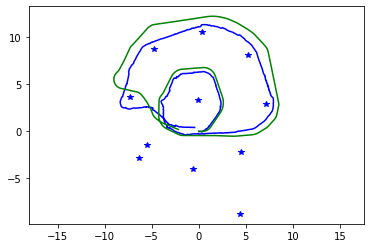

iteración ICM :  25


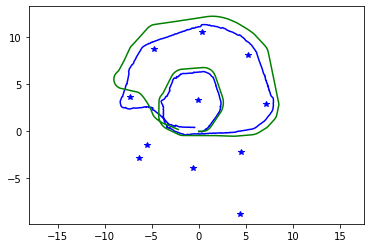

iteración ICM :  26


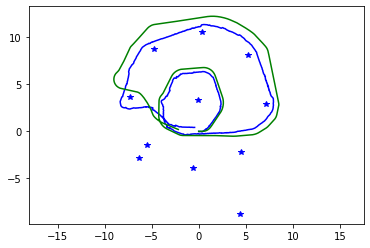

iteración ICM :  27


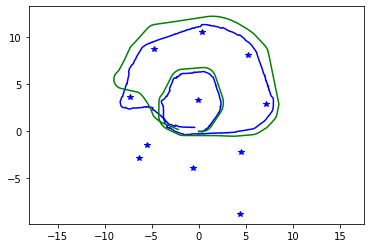

iteración ICM :  28


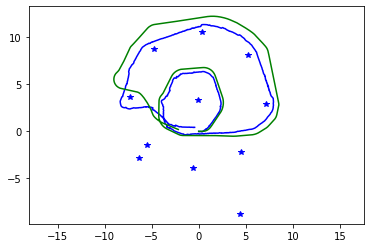

iteración ICM :  29


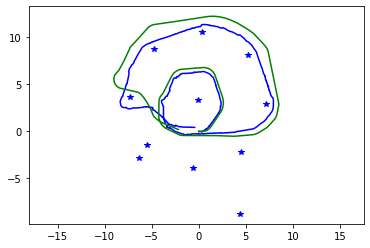

iteración ICM :  30


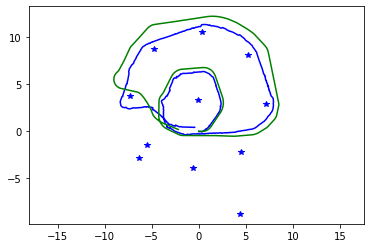

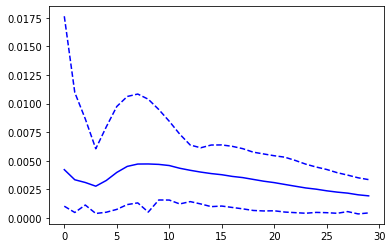

In [3]:
#Importa todos los paquetes
import numpy as np
import numpy.matlib
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.signal import medfilt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.optimize import fmin
import matplotlib.pyplot as plt


#Permiso para acceder a datos del Drive
#al correr esto te va a aparecer un link... entrá y darle permitir... la cuenta es javigimeneznn@gmail.com_______contraseña:jG32227013
import scipy.io as sio
#from google.colab import drive  # Load the Drive helper and mount
#drive.mount('/content/drive')# This will prompt for authorization.

#lectura de los datos de experimentación del paper IJAC2018
#data = sio.loadmat('/content/drive/My Drive/Datasets/IJAC2018/data_IJAC2018.mat')#load from drive the .m with the database
data=sio.loadmat('data_IJAC2018.mat')
odometria = np.array(data['odometry'])
z = np.array(data['observations'])
u = np.array(data['velocities'])
del(data)

print(odometria.shape)
print(z.shape)
print(u.shape)


#parámetros y constantes
N=30  #cantidad de iteraciones de ICM
deltat=0.1  #periodo de muestreo
Tf=z.shape[1]  #cantidad total de periodos de muestreo
L=1000  #cota superior de la cantidad de objetos
Q=np.eye(2)  #matriz de covarianza de las observaciones
R=np.eye(3) #matriz de covarianza del motion model
cte_odom=1.0  #S=diag([cte_odom,cte_odom,cte_odom]) matriz de peso de los datos odométricos
cota=300.0  #cantidad de veces que hay q ver un arbol para q se considere un arbol
dist_thr=1.0  #distancia máxima para que dos obs sean consideradas del mismo objeto
dist_thr_obs=1  #distancia máxima para que dos obs sean consideradas del mismo objeto en el proceso de filtrado de las observaciones
rango_laser_max=10.0  #alcance máximo del laser
radio=0.137 #radio promedio de los árboles

#preparo las observaciones
zz=np.minimum(z+radio,z*0.0+rango_laser_max)  #guarda las observaciones laser... si la distancia de obs es mayor a rango_laser_max se setea directamente en rango_laser_max##################### ITERACION ICM 0 #####################


#FUNCIONES AUXILIARES
def entrepi(angulo):#retorna el ángulo equivalente entre -pi y pi
  angulo=np.mod(angulo,2*np.pi)
  if angulo>np.pi:
    angulo=angulo-2*np.pi
  return angulo

def filtrar_y(y,cant_obs_i,Lact):#limpio ubicaciones poco observadas y unifico arboles muy cercanos
  cant_obs_i=cant_obs_i[0:Lact] #saco ceros innecesarios
  ind=np.where(cant_obs_i<cota)[0]  #indices de arboles poco observados
  if ind.size>0:  #si hay arboles poco observados
      Lact=Lact-ind.size  #reduzco la cantidad de arboles observados hasta el momento
      ind2=np.where(cant_obs_i>=cota)[0] #indices de arboles observados muchas veces
      y=y[:,ind2] #elimino las posiciones estimadas de los arboles vistos pocas veces
      np.concatenate((y,np.zeros((2,len(ind)))),axis=1)  #le devuelvo a y su dimension original completando con ceros
      cant_obs_i=cant_obs_i[ind2] #elimino las cantidades observadas de los arboles vistos pocas veces
  a=squareform(pdist(y[:,0:Lact].T))  #calculo la matriz de distancias 2a2 de todas las posiciones de arboles observados
  a[a==0]=np.amax(a) #reemplazo los ceros (de la diagonal generalmente) para que no interfiera en el calculo de minimos en las siguientes lineas
  b=np.argmin(a,axis=0) #vector que contiene contiene el valor j en la entrada i, si el arbol j es el más cercano al arbol i
  a=np.amin(a,axis=0) #vector que contiene la distancia minima entre los arboles i y j de la linea anterior
  ind=np.where(a<dist_thr)[0] #indices donde la distancia entre dos arboles es muy chica
  c=np.arange(Lact)  #contiene los indices de los arboles
  if ind.size>0:  #si hay arboles muy cercanos los unifico
      for i in range(len(ind)): #el arbol ind[i] tiene al arbol b[ind[i]] muy cercano
          c[c==c[b[ind[i]]]]=c[ind[i]]  #le asigno al arbol b[ind[i]] (y a todos los cercanos a él) el indice del arbol ind[i]
  for i in range(Lact-1,-1,-1):
      if len(c[c==i])==0:  #si el arbol i perdió su indice por ser cercano a uno de indice menor
          c[c>=i]=c[c>=i]-1 #a todos los de indice mayor a i le resto 1... ya que el indice i ya no existe
  Lact=max(c)+1 #actualizo la cantidad de arboles observados luego del filtro
  yy=np.zeros((2,L)) #contendrá la posición media ponderada de acuerdo a cant_obs_i entre todos los arboles unificados por estar cercanos 
  cant_obs=np.zeros(L)  #reemplazará a cant_obs_i
  for i in range(Lact):
      cant_obs[i]=np.sum(cant_obs_i[c==i])
      yy[:,i]=np.sum(y[:,c==i]*np.matlib.repmat(cant_obs_i[c==i],2,1),axis=1)/cant_obs[i] #calculo el centro de cada nuevo cluster
  return yy,cant_obs,Lact

def actualizar_mapa(mapa,yy,obs,Lact):
    #mapa es la estimación de los árboles que se tiene hasta el momento dentro de la iteracion ICM
    #yy es la estimación de los árboles que se usará para realizar el etiquetado de las obs nuevas. En la iteracion 0 yy=mapa, pero en las iteraciones siguientes yy es el mapa final estimado en la iteración ICM anterior
    if Lact==0:#este bucle es solamente para t=0 de la iteración ICM 0
        c=fcluster(linkage(pdist(obs)),dist_thr)-1  #calculo clusters iniciales
        Lact=np.max(c)+1  #cantidad de arboles iniciales
        for i in range(Lact):
            mapa[:,i]=np.mean(obs[c==i,:],axis=0).T #calculo el centro de cada cluster
            cant_obs_i[i]=len(c[c==i])
    else:
        #me fijo si las observaciones corresponden a un arbol existente
        distancias=cdist(yy[:,:Lact].T,obs)#matriz de distancias entre yy y las obs nuevas
        min_dist=np.amin(distancias,axis=0)#distancia minima desde cada obs a un arbol de yy
        c=np.argmin(distancias,axis=0)#etiqueta del arbol de yy que minimiza la distancia a cada obs nueva
        c[min_dist>dist_thr]=-1#si esta lejos de los arboles de yy le asigno la etiqueta -1 momentaneamente
        #armo cluster con observaciones de arboles nuevos
        ztt=obs[min_dist>dist_thr,:]#extraigo las obs nuevas que estan lejos de los árboles de yy
        if ztt.shape[0]>1:#si hay mas de una observacion de un arbol no mapeado aun
            cc=Lact+fcluster(linkage(pdist(ztt[:,2:4])),dist_thr)-1 #calculo clusters y le coloco una etiqueta nueva (a partir de Lact=max etiqueta+1)
            c[c==-1]=cc#a todos los arboles con etiqueta -1 le asigno su nueva etiqueta
        elif ztt.shape[0]==1:#si hay sólo una observacion de un arbol no mapeado aun
            c[c==-1]=Lact
        Lact=np.amax(np.append(c+1,Lact))#actualizo la cantidad de arboles mapeados hasta el momento
        #actualizo (o creo) ubicación de arboles observados
        for i in range(Lact):
            if len(c[c==i])>0:
                mapa[:,i]=np.sum(zt[c==i,2:4],axis=0)/(cant_obs_i[i]+len(c[c==i]))+mapa[:,i]*cant_obs_i[i]/(cant_obs_i[i]+len(c[c==i]))
                cant_obs_i[i]=cant_obs_i[i]+len(c[c==i])
    return mapa,cant_obs_i,c,Lact

def filtrar_z(z):
  #esta functión elimina observaciones aisladas o de rango máximo.
  #zz es una matriz de 2 columnas que alista una abajo de otra las distancias y los angulos en los cuales hay una observación "positiva".
  z=medfilt(z)  #filtro de mediana con ventana 3 para borrar observaciones laser outliers
  zz=z+0.0  #copia para no sobreescribir
  ind=np.where(z>=rango_laser_max);ind=ind[0]  #hallo direcciones sin observacion
  nind=np.where(z<rango_laser_max);nind=nind[0]  #hallo direcciones con observacion
  if len(nind)>1:
    z=z[nind] #elimino direcciones sin observacion
    z=np.concatenate((np.cos(nind*np.pi/180.0)*z,np.sin(nind*np.pi/180.0)*z)).reshape((len(nind),2),order='F') #ahora z tiene puntos 2D con la ubicacion relativa de las observaciones realizadas
    c=squareform(pdist(z))  #matriz de distrancia entre obs
    c[c==0]=100 #modifico la diagonal con un numero grande
    c=np.amin(c,axis=0) #calculo la distancia al objeto más cercano de cada observacion
    nind=nind[c<=dist_thr] #elimino direcciones aisladas
    zz=np.concatenate((zz[nind],nind*np.pi/180.0)).reshape((len(nind),2),order='F') #ahora zz contiene las distancias y la direccion (en radianes) de las observaciones no aisladas
    zzz=np.concatenate((zz[:,0],zz[:,0])).reshape((len(nind),2),order='F')*np.concatenate((np.cos(zz[:,1]),np.sin(zz[:,1]))).reshape((len(nind),2),order='F') #contiene la posicion relativa de las observaciones no aisladas
    zz=np.concatenate((zz,zzz),axis=1)
  else:
    zz=np.array([])
  return zz

def tras_rot_z(x,z):#transforma del body frame al global frame
  x=x.reshape((3,1))
  ct=np.cos(x[2]-np.pi/2.0)[0]
  st=np.sin(x[2]-np.pi/2.0)[0]
  R=np.array([[ct,st],[-st,ct]])
  z[:,2:4]=np.matmul(z[:,2:4],R)+np.matlib.repmat(x[0:2].T,z.shape[0],1)
  return z

def minimizar_xn(zz,yy,xx_ant,xx_pos,uu,odometria):
  #yy contiene las ubicaciones estimadas hasta el momento de los arboles observados una abajo de la otra, repitiendo observaciones repetidas e ignorando ubicaciones no observadas
  #zz contiene las observaciones realizadas una abajo de la otra. La primer columna contiene distancias y la segunda ángulos relativos al laser del robot
  global zopt,yopt,u_ant_opt,x_ant_opt,u_act_opt,x_pos_opt,odo_opt
  zopt=zz;yopt=yy;u_ant_opt=uu[:,0];x_ant_opt=xx_ant.reshape((3,1));u_act_opt=uu[:,1];x_pos_opt=xx_pos.reshape((3,1));odo_opt=odometria;
  x=fmin(fun_xn,(x_ant_opt+x_pos_opt)/2.0,xtol=0.001,disp=0)
  return x

def fun_xn(x):
  global zopt,x_pos_opt,u_act_opt,odo_opt
  z=zopt;x_pos=x_pos_opt;u_act=u_act_opt;odo=odo_opt;
  f=fun_x(x)
  x=x.reshape((3,1))
  gg=g(x,u_act)-x_pos
  gg[2]=entrepi(gg[2])
  Rotador=Rota(x[2][0])
  ooo=np.zeros((3,1))
  ooo[0:2]=np.matmul(Rota(odo[2,1]),(odo[0:2,2]-odo[0:2,1]).reshape((2,1)))-np.matmul(Rotador,x_pos[0:2]-x[0:2])
  ooo[2]=odo[2,2]-odo[2,1]-x_pos[2]+x[2]
  ooo[2]=entrepi(ooo[2])
  f=f+np.matmul(np.matmul(gg.T,R),gg)+cte_odom*np.matmul(ooo.T,ooo)
  return f

def minimizar_x(zz,yy,xx_ant,uu_ant,odometria):
  #yy contiene las ubicaciones estimadas hasta el momento de los arboles observados una abajo de la otra, repitiendo observaciones repetidas e ignorando ubicaciones no observadas
  #zz contiene las observaciones realizadas una abajo de la otra. La primer columna contiene distancias y la segunda ángulos relativos al laser del robot
  global zopt,yopt,u_ant_opt,x_ant_opt,odo_opt
  zopt=zz;yopt=yy;u_ant_opt=uu_ant;x_ant_opt=xx_ant.reshape((3,1));odo_opt=odometria;
  x=fmin(fun_x,g(x_ant_opt,u_ant_opt),xtol=0.001,disp=0);
  return x

def fun_x(x):
  global zopt,x_ant_opt,u_ant_opt,odo_opt
  z=zopt;x_ant=x_ant_opt;u_ant=u_ant_opt;odo=odo_opt;
  gg=x.reshape((3,1))-g(x_ant,u_ant)
  gg[2]=entrepi(gg[2])
  hh=h(x,z)
  Rotador=Rota(x_ant[2][0])
  ooo=np.zeros((3,1))
  ooo[0:2]=np.matmul(Rota(odo[2,0]),(odo[0:2,1]-odo[0:2,0]).reshape((2,1)))-np.matmul(Rotador,x[0:2].reshape((2,1))-x_ant[0:2])
  ooo[2]=odo[2,1]-odo[2,0]-x[2]+x_ant[2]
  ooo[2]=entrepi(ooo[2])
  f=np.matmul(np.matmul(gg.T,R),gg)+hh+cte_odom*np.matmul(ooo.T,ooo)
  return f

def h(xt,zt):
  global yopt
  y=yopt
  alfa=zt[:,1]+xt[2]-np.pi/2.0
  zc=zt[:,0]*np.cos(alfa)
  zs=zt[:,0]*np.sin(alfa)
  hh=np.concatenate((xt[0]+zc,xt[1]+zs)).reshape((len(alfa),2),order='F')-y
  hhh=np.matmul(hh,Q)
  hh=np.sum(hhh*hh)
  return hh

def g(xt,ut):
  xt=xt.reshape((3,1))
  ut=ut.reshape((2,1))
  S=np.array([[(np.cos(xt[2]))[0],0.0],[np.sin(xt[2])[0],0.0],[0.0,1.0]])
  gg=xt+deltat*np.matmul(S,ut).reshape((3,1))
  return gg

def Rota(theta):
  A=np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  return A

def calc_cambio(y,mapa_viejo):
    min_dist=np.amin(cdist(mapa_viejo.T,y.T),axis=0)
    cambio_minimo=np.amin(min_dist)
    cambio_maximo=np.amax(min_dist)
    cambio_medio=np.mean(min_dist)
    return cambio_minimo,cambio_maximo,cambio_medio

def graficar(x,yy):
    plt.plot(x[0],x[1], 'b')
    plt.plot(odometria[0],odometria[1], 'g')
    plt.plot(yy[0],yy[1], 'b*')
    plt.axis('equal')
    fig=plt.show()

def graficar_cambio(cambios_minimos,cambios_maximos,cambios_medios):
    plt.plot(cambios_minimos, 'b--')
    plt.plot(cambios_maximos, 'b--')
    plt.plot(cambios_medios, 'b')
    fig=plt.show()


#inicializacion de variables y arreglos auxiliares
x0=np.zeros((3,1))  #guarda la pose actual (inicial en esta linea) del DDMR
y=np.zeros((2,L)) #guarda la posicion de los a lo sumo L arboles del entorno
cant_obs_i=np.zeros(L)  #guarda la cantidad de veces que se observó el i-ésimo árbol
x=np.zeros((3,Tf))  #guarda la pose del DDMR en los Tf periodos de muestreo

#Iteracion inicial ICM
xt=x0+0.0 #pose inicial
z=filtrar_z(zz[:,0])  #filtro la primer observacion [dist ang x y] x #obs
zt=tras_rot_z(xt,z) #rota y traslada las observaciones de acuerdo a la pose actual
y,cant_obs_i,c,Lact=actualizar_mapa(y,y,zt[:,2:4],0)

#BUCLE TEMPORAL
for t in range(1,Tf):
    xtc=g(xt,u[:,t-1])  #actualizo cinemáticamente la pose
    z=filtrar_z(zz[:,t])  #filtro observaciones no informativas del tiempo t: [dist ang x y] x #obs
    if z.shape[0]==0:xt=xtc;x[:,t]=xt.T;continue#si no hay observaciones pasar al siguiente periodo de muestreo
    zt=tras_rot_z(xtc,z)  #rota y traslada las observaciones de acuerdo a la pose actual
    y,cant_obs_i,c,Lact=actualizar_mapa(y,y,zt[:,2:4],Lact)  #actualizo (o creo) ubicación de arboles observados
    xt=minimizar_x(z[:,0:2],y[:,c].T,xt,u[:,t-1],odometria[:,t-1:t+1])
#     xt=xtc+0.0 #actualiza con el modelo cinemático para independizarse del optimizador
    x[:,t]=xt

#filtro ubicaciones estimadas
[y,cant_obs_i,Lact]=filtrar_y(y,cant_obs_i,Lact)
yy=y[:,:Lact]

#CALCULO CAMBIOS
mapa_viejo=yy+0.0
cambios_minimos=np.zeros(N)
cambios_maximos=np.zeros(N)
cambios_medios=np.zeros(N)

graficar(x,yy)#gráficos


#Iteraciones ICM
for iteracionICM in range(N):
    print('iteración ICM : ',iteracionICM+1)
    xt=x0+0.0 #pose inicial
    y=np.zeros((2,L)) #guarda la posicion de los a lo sumo L arboles del entorno
    cant_obs_i=np.zeros(L)  #guarda la cantidad de veces que se observó el i-ésimo árbol
    z=filtrar_z(zz[:,0])  #filtro la primer observacion [dist ang x y] x #obs
    if z.shape[0]==0:continue#si no hay observaciones pasar al siguiente periodo de muestreo
    zt=tras_rot_z(xt,z) #rota y traslada las observaciones de acuerdo a la pose actual
    y,cant_obs_i,c,Lact=actualizar_mapa(y,yy,zt[:,2:4],Lact)  #actualizo (o creo) ubicación de arboles observados

    #BUCLE TEMPORAL
    for t in range(1,Tf):
        z=filtrar_z(zz[:,t])  #filtro observaciones no informativas del tiempo t: [dist ang x y] x #obs
        if z.shape[0]==0:xt=(xt.reshape(3)+x[:,t+1])/2.0;x[:,t]=xt;continue#si no hay observaciones pasar al siguiente periodo de muestreo
        zt=tras_rot_z(x[:,t],z)  #rota y traslada las observaciones de acuerdo a la pose actual
        y,cant_obs_i,c,Lact=actualizar_mapa(y,yy,zt[:,2:4],Lact)  #actualizo (o creo) ubicación de arboles observados
        if t+1<Tf:
            xt=minimizar_xn(z[:,0:2],y[:,c].T,xt,x[:,t+1],u[:,t-1:t+1],odometria[:,t-1:t+2])
        else:
            xt=minimizar_x(z[:,0:2],y[:,c].T,xt,u[:,t-1],odometria[:,t-1:t+1])
        x[:,t]=xt
    
    #filtro ubicaciones estimadas
    [yy,cant_obs_i,Lact]=filtrar_y(y,cant_obs_i,Lact)
    yy=yy[:,:Lact]
    
    #CALCULO DE CAMBIOS
    [cambio_minimo,cambio_maximo,cambio_medio]=calc_cambio(yy,mapa_viejo)
    cambios_minimos[iteracionICM]=cambio_minimo
    cambios_maximos[iteracionICM]=cambio_maximo
    cambios_medios[iteracionICM]=cambio_medio
    mapa_viejo=yy+0.0

    graficar(x,yy)#gráficos
graficar_cambio(cambios_minimos,cambios_maximos,cambios_medios)

